# CT Reconstruction Pipeline Notebook

This notebook guides you through the steps of the CT reconstruction pipeline, using the modules defined in the `src/` directory.

**Workflow:**
1.  **Setup:** Import modules and configure logging.
2.  **Load Data:** Load projection images and calibration data.
3.  **Preprocess:** Apply corrections (flat/dark field, log conversion, etc.).
4.  **Reconstruct:** Perform 3D reconstruction (FBP, FDK, SIRT, etc.).
5.  **Postprocess:** Apply filtering, masking, and scaling.
6.  **Visualize & Save:** Display results and save the final volume.
7.  **Evaluate:** Calculate metrics against ground truth (optional).

**Before running:**
* Ensure all necessary libraries (`numpy`, `scipy`, `matplotlib`, `scikit-image`, `imageio`, `astra-toolbox`/`tigre` if needed) are installed.
* Make sure the `src/` directory containing `config.py`, `data_loader.py`, etc., is in the same directory as this notebook or accessible via the Python path.
* **Crucially, update `src/config.py`** with the correct paths and parameters for your specific data and setup.

## 1. Setup: Imports and Configuration

In [1]:
import os
import sys
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

# --- Add src directory to Python path ---
# Assumes the notebook is in the project root, and modules are in ./src/
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
    print(f"Added {SRC_DIR} to sys.path")
else:
    print(f"{SRC_DIR} already in sys.path")

# --- Import Project Modules ---
# Use importlib to allow reloading modules if they change during the session
import importlib
try:
    import config_tiff as config
    import data_loader
    import preprocess
    import reconstruction
    import postprocess
    import visualize
    import evaluate
    import utils
    print("Successfully imported project modules.")
except ImportError as e:
    print(f"Error importing modules: {e}\nPlease ensure 'src' directory is correctly structured and in sys.path.")
    # Stop execution if modules can't be loaded
    raise

# --- Reload modules (useful during development) ---
# Uncomment the lines below if you modify the .py files and want to reload them without restarting the kernel
# importlib.reload(config)
# importlib.reload(data_loader)
# importlib.reload(preprocess)
# importlib.reload(reconstruction)
# importlib.reload(postprocess)
# importlib.reload(visualize)
# importlib.reload(evaluate)
# importlib.reload(utils)
# print("Modules reloaded.")

# --- Basic Logging Setup ---
# The modules themselves configure logging, but we can ensure the level here
log_level = getattr(logging, config.LOG_LEVEL, logging.INFO)
logging.basicConfig(level=log_level, 
                    format='%(asctime)s [%(levelname)-5.5s] %(name)-15s - %(message)s',
                    force=True) # force=True reconfigures root logger
log = logging.getLogger(__name__)
log.info(f"Logging level set to: {logging.getLevelName(log.getEffectiveLevel())}")

# --- Ensure Output Dirs Exist ---
try:
    if hasattr(config, 'ensure_output_dirs_exist'):
         config.ensure_output_dirs_exist()
    else:
         dirs_to_create = [config.OUTPUT_DIR, config.RECON_SLICES_DIR, config.RECON_VOLUME_DIR, config.PLOT_DIR]
         for d in dirs_to_create: os.makedirs(d, exist_ok=True)
         log.info("Checked/created output directories.")
except Exception as e:
    log.error(f"Failed to create output directories: {e}")
    raise

# --- Configuration Overview ---
# Display some key config values
print("\n--- Key Configuration ---")
print(f"Projection Dir: {config.PROJECTION_DIR}")
print(f"Output Dir: {config.OUTPUT_DIR}")
print(f"Geometry: {config.GEOMETRY_TYPE}")
print(f"Recon Algorithm: {config.RECONSTRUCTION_ALGORITHM}")
print(f"Perform Evaluation: {config.PERFORM_EVALUATION}")
print("-------------------------")

Added /home/syscall/Documents/bohboh3/src to sys.path
Configuration loaded.
Configuration loaded.


2025-05-02 02:16:42,046 - INFO - reconstruction - ASTRA Toolbox library found.
2025-05-02 02:16:42,169 - INFO - reconstruction - scikit-image library found (for basic FBP).
2025-05-02 02:16:42,359 - INFO - evaluate - scikit-image metrics library found.
2025-05-02 02:16:42,360 [INFO ] __main__        - Logging level set to: INFO


Successfully imported project modules.
Checked/created output directories.

--- Key Configuration ---
Projection Dir: /home/syscall/Documents/bohboh3/data/projections/walnut
Output Dir: /home/syscall/Documents/bohboh3/output
Geometry: cone
Recon Algorithm: FDK
Perform Evaluation: False
-------------------------


## 2. Load Data

Load projections, flat fields, and dark fields using the `data_loader` module.

In [2]:
log.info("--- Running Step 2: Loading Data ---")
start_time = time.time()

# Load projections
raw_projections = data_loader.load_projections(config)

# Proceed only if projections loaded successfully
if raw_projections is not None:
    log.info(f"Loaded raw projections with shape: {raw_projections.shape}")
    
    # Use detected shape for loading calibration images
    detected_shape = (raw_projections.shape[1], raw_projections.shape[2])
    
    # Load flat fields
    flat_field_data = data_loader.load_flat_fields(config, detected_shape)
    if flat_field_data is not None:
        log.info(f"Loaded flat field data with shape: {flat_field_data.shape}")
    else:
        log.warning("Flat field data not loaded (check config/path or disable correction).")
        
    # Load dark fields
    dark_field_data = data_loader.load_dark_fields(config, detected_shape)
    if dark_field_data is not None:
        log.info(f"Loaded dark field data with shape: {dark_field_data.shape}")
    else:
        log.warning("Dark field data not loaded (check config/path or disable correction).")
        
    log.info(f"Data loading finished in {time.time() - start_time:.2f} seconds.")
else:
    log.error("Failed to load projection data. Cannot proceed.")
    # Stop execution by raising an error or using assert
    assert raw_projections is not None, "Projection loading failed."

2025-05-02 02:16:42,368 [INFO ] __main__        - --- Running Step 2: Loading Data ---
2025-05-02 02:16:42,369 [INFO ] data_loader     - Searching for projection files matching: /home/syscall/Documents/bohboh3/data/projections/walnut/*_walnut_dose_10_*.tif
2025-05-02 02:16:42,372 [INFO ] data_loader     - Found 361 projection files to load.
2025-05-02 02:16:42,405 [INFO ] data_loader     - Detected projection shape: (2368, 2240) (height, width)
2025-05-02 02:16:49,597 [INFO ] data_loader     - Loaded 361 projections successfully.
2025-05-02 02:16:55,272 [INFO ] data_loader     - Successfully loaded 361 projections.
2025-05-02 02:16:55,273 [INFO ] data_loader     - Final projection stack shape: (361, 2368, 2240) (projections, height, width)
2025-05-02 02:16:55,273 [INFO ] data_loader     - Updated config: NUM_PROJECTIONS=361, angles recalculated.
2025-05-02 02:16:55,360 [INFO ] __main__        - Loaded raw projections with shape: (361, 2368, 2240)
2025-05-02 02:16:55,360 [INFO ] data_lo

## 3. Preprocess Data

Apply corrections and transformations to get the attenuation sinogram.

2025-05-02 02:16:55,378 [INFO ] __main__        - --- Running Step 3: Preprocessing Data ---
2025-05-02 02:16:55,380 [INFO ] preprocess      - --- Starting Preprocessing Pipeline ---
2025-05-02 02:16:55,381 [INFO ] preprocess      - Flat and dark field correction disabled. Returning raw projections.
2025-05-02 02:16:55,384 [INFO ] preprocess      - Flat/Dark field correction step completed.
2025-05-02 02:16:55,385 [INFO ] preprocess      - Scatter correction disabled.
2025-05-02 02:16:55,386 [INFO ] preprocess      - Scatter correction step completed (placeholder).
2025-05-02 02:16:55,386 [INFO ] preprocess      - Applying negative logarithm conversion (Transmission -> Attenuation)...
2025-05-02 02:16:57,695 [INFO ] preprocess      - Log conversion successful.
2025-05-02 02:17:07,619 [INFO ] preprocess      - Log conversion step completed.
2025-05-02 02:17:07,620 [INFO ] preprocess      - Beam hardening correction disabled.
2025-05-02 02:17:07,621 [INFO ] preprocess      - Beam hardeni

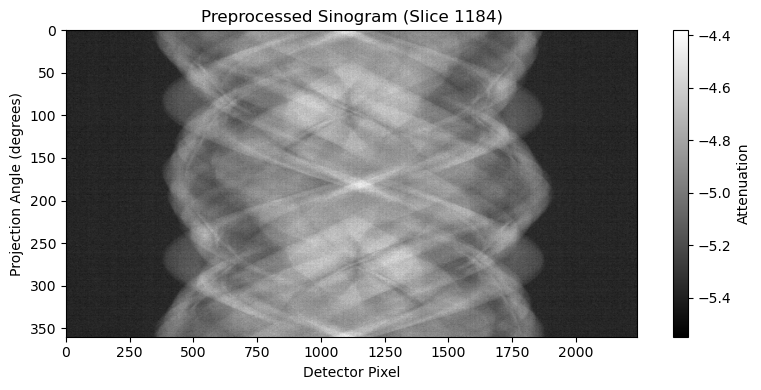

In [3]:
log.info("--- Running Step 3: Preprocessing Data ---")
start_time = time.time()

preprocessed_sinogram = preprocess.preprocess_data(
    raw_projections, flat_field_data, dark_field_data, config
)

if preprocessed_sinogram is not None:
    log.info(f"Preprocessing successful. Sinogram shape: {preprocessed_sinogram.shape}")
    log.info(f"Preprocessing finished in {time.time() - start_time:.2f} seconds.")
    
    # Visualize a slice of the preprocessed sinogram
    log.info("Displaying sample preprocessed sinogram slice...")
    vis_slice_idx = preprocessed_sinogram.shape[1] // 2 # Middle slice
    plt.figure(figsize=(8, 4))
    plt.imshow(
        preprocessed_sinogram[:, vis_slice_idx, :], 
        cmap=config.VISUALIZATION_CMAP, 
        aspect='auto',
        extent=[0, preprocessed_sinogram.shape[2], config.ANGLE_END_DEG, config.ANGLE_START_DEG]
    )
    plt.title(f'Preprocessed Sinogram (Slice {vis_slice_idx})')
    plt.xlabel('Detector Pixel')
    plt.ylabel('Projection Angle (degrees)')
    plt.colorbar(label='Attenuation')
    plt.tight_layout()
    plt.show()
else:
    log.error("Preprocessing failed. Cannot proceed.")
    assert preprocessed_sinogram is not None, "Preprocessing failed."

## 4. Reconstruct Volume

Perform the 3D reconstruction using the selected algorithm.

In [ ]:
# Notebook Cell 4

log.info("--- Running Step 4: Reconstructing Volume ---")
start_time = time.time()

# --- Add Dask check and compute here ---
if preprocessed_sinogram is not None:
    try:
        import dask.array as da
        if isinstance(preprocessed_sinogram, da.Array):
            log.info(f"Preprocessed sinogram is a Dask array (shape: {preprocessed_sinogram.shape}). Computing to NumPy array...")
            compute_start = time.time()
            # This forces computation and returns a NumPy array
            preprocessed_sinogram_np = preprocessed_sinogram.compute()
            log.info(f"Dask compute finished in {time.time() - compute_start:.2f} seconds. NumPy array shape: {preprocessed_sinogram_np.shape}")
            # Ensure float32 type after compute
            preprocessed_sinogram_np = preprocessed_sinogram_np.astype(np.float32)
        else:
            # It's already a NumPy array (or something else)
            log.info("Preprocessed sinogram is not a Dask array.")
            preprocessed_sinogram_np = preprocessed_sinogram.astype(np.float32) # Ensure dtype

    except ImportError:
        log.warning("Dask library not found. Assuming preprocessed_sinogram is NumPy array.")
        preprocessed_sinogram_np = preprocessed_sinogram.astype(np.float32) # Ensure dtype
    except Exception as e:
        log.error(f"Error during Dask check/compute: {e}")
        preprocessed_sinogram_np = None # Mark as error
else:
    preprocessed_sinogram_np = None # Propagate None if preprocessing failed

# --- Call reconstruction with the NumPy array ---
if preprocessed_sinogram_np is not None:
    reconstructed_volume = reconstruction.reconstruct_volume(preprocessed_sinogram_np, config)
else:
    reconstructed_volume = None # Skip reconstruction if data is invalid

# --- Rest of the cell ---
if reconstructed_volume is not None:
    log.info(f"Reconstruction successful. Volume shape: {reconstructed_volume.shape}")
    log.info(f"Reconstruction finished in {time.time() - start_time:.2f} seconds.")
else:
    log.error("Reconstruction failed. Cannot proceed.")
    assert reconstructed_volume is not None, "Reconstruction failed."

2025-05-02 02:17:17,353 [INFO ] __main__        - --- Running Step 4: Reconstructing Volume ---
2025-05-02 02:17:17,354 [INFO ] reconstruction  - --- Starting Reconstruction ---
2025-05-02 02:17:17,354 [INFO ] reconstruction  - Starting ASTRA reconstruction using algorithm: FDK
2025-05-02 02:17:17,355 [WARNI] reconstruction  - Center of Rotation offset specified, but applying it in ASTRA requires specific vector adjustments (not implemented in this basic example). Reconstruction may be shifted/blurred.
2025-05-02 02:17:17,355 [INFO ] reconstruction  - ASTRA projection geometry created.
2025-05-02 02:17:17,356 [INFO ] reconstruction  - ASTRA volume geometry created.
2025-05-02 02:17:17,357 [INFO ] reconstruction  - Transposed sinogram for ASTRA to shape: (2368, 361, 2240)


: 

## 5. Postprocess Volume

Apply optional filtering, masking, and intensity scaling.

In [ ]:
log.info("--- Running Step 5: Postprocessing Volume ---")
start_time = time.time()

postprocessed_volume = postprocess.postprocess_volume(reconstructed_volume, config)

if postprocessed_volume is not None:
    log.info(f"Postprocessing successful. Final volume shape: {postprocessed_volume.shape}")
    final_volume = postprocessed_volume # Use the processed volume
else:
    log.warning("Postprocessing failed or returned None. Using un-postprocessed volume.")
    final_volume = reconstructed_volume # Fallback
    
log.info(f"Postprocessing finished in {time.time() - start_time:.2f} seconds.")

## 6. Visualize & Save Results

Display orthogonal slices and save the final volume.

In [ ]:
log.info("--- Running Step 6: Visualizing and Saving Results ---")
start_time = time.time()

# Visualize orthogonal slices
log.info("Displaying orthogonal slices of the final volume...")
visualize.plot_reconstructed_slices(
    final_volume,
    cfg=config,
    # Override show/save behavior for notebook display
    # Temporarily modify config or pass args if visualize func supports it
)
# Ensure plot shows in notebook if config.SHOW_PLOTS is False
plt.show() 

# Save the final volume
volume_filename = f"notebook_reconstructed_volume_{config.RECONSTRUCTION_ALGORITHM}.mha"
save_success = utils.save_volume(final_volume, volume_filename, cfg=config, file_format='mha')

if save_success:
    log.info(f"Final volume saved to {os.path.join(config.RECON_VOLUME_DIR, volume_filename)}")
else:
    log.error("Failed to save the final volume.")

log.info(f"Visualization and saving finished in {time.time() - start_time:.2f} seconds.")

## 7. Evaluate (Optional)

Calculate quality metrics if ground truth data is available and evaluation is enabled.

In [ ]:
if config.PERFORM_EVALUATION:
    log.info("--- Running Step 7: Evaluating Reconstruction ---")
    start_time = time.time()
    
    # Load ground truth
    ground_truth_volume = data_loader.load_ground_truth(config)
    
    if ground_truth_volume is not None:
        log.info(f"Loaded ground truth volume with shape: {ground_truth_volume.shape}")
        # Calculate metrics
        evaluation_results = evaluate.calculate_metrics(final_volume, ground_truth_volume, config)
        
        if evaluation_results:
            print("\n--- Evaluation Results ---")
            for metric, value in evaluation_results.items():
                print(f"{metric}: {value:.6f}")
            print("------------------------")
        else:
            log.warning("Metric calculation failed or returned no results.")
            
        log.info(f"Evaluation finished in {time.time() - start_time:.2f} seconds.")
    else:
        log.warning("Evaluation enabled, but failed to load ground truth volume. Skipping metrics calculation.")
else:
    log.info("--- Evaluation Skipped (disabled in config) ---")

print("\nNotebook execution finished.")